In [1]:
!pip install xgboost

In [28]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import xgboost
%matplotlib inline
from nltk.corpus import reuters, stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import pandas as pd
from collections import Counter

# Code to download corpora
import nltk
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Tony\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tony\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tony\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
bitcoin_df = pd.read_csv('Data/bitcoin_df.csv', parse_dates=True)
bitcoin_df = bitcoin_df.rename(columns={"Unnamed: 0":"date"})
bitcoin_df['date'] = pd.to_datetime(bitcoin_df['date']).dt.date
bitcoin_df.head()

,date,datetime,open,high,low,close,volume,returns,class
0,2017-08-18,1.503014e+09,4285.08,4371.52,3938.77,4108.37,1199.888264,-0.041238,0
1,2017-08-19,1.503101e+09,4108.37,4184.69,3850.00,4139.98,381.309763,0.007694,0
2,2017-08-20,1.503187e+09,4120.98,4211.08,4032.62,4086.29,467.083022,-0.012969,0
3,2017-08-21,1.503274e+09,4069.13,4119.62,3911.79,4016.00,691.743060,-0.017201,0
4,2017-08-22,1.503360e+09,4016.00,4104.82,3400.00,4040.00,966.684858,0.005976,0


In [4]:
google_trend_df = pd.read_csv('Data/btc_google_trend.csv', parse_dates=True)
google_trend_df['date'] = pd.to_datetime(google_trend_df['date']).dt.date
google_trend_df = google_trend_df.rename(columns={"bitcoin":"google trend"})
google_trend_df.head()

,date,google trend
0,2017-08-18,1967
1,2017-08-19,1844
2,2017-08-20,1704
3,2017-08-21,1702
4,2017-08-22,1893


In [5]:
reddit_sentiments_df = pd.read_csv('Data/reddit_sentiments_df.csv')
reddit_sentiments_df.drop('Unnamed: 0', axis=1, inplace=True)
reddit_sentiments_df = reddit_sentiments_df.rename(columns={"text":"Reddit text"})
reddit_sentiments_df.head()

,datetime,Reddit text,Reddit compound,Reddit positive,Reddit negative,Reddit neutral
0,1.503014e+09,it´s an old bitcoin breadwallet! This is good ...,0.9999,0.132,0.082,0.786
1,1.503101e+09,My favourite part is when he calls r/btc more ...,0.9998,0.122,0.090,0.788
2,1.503187e+09,That feeling when your friends talked you out ...,0.9998,0.128,0.109,0.763
3,1.503274e+09,if you had any doubt: this is how you fight bi...,0.9998,0.129,0.104,0.767
4,1.503360e+09,&gt; At the end she broke down crying saying ...,0.9998,0.131,0.108,0.761


In [6]:
google_sentiments_df = pd.read_csv('Data/google_sentiment_df.csv')
google_sentiments_df['date'] = pd.to_datetime(google_sentiments_df['date']).dt.date
google_sentiments_df

,date,Google text,Google compound,Google positive,Google negative,Google neutral
0,2017-08-18,Hedge funds have long been a popular choice fo...,0.9848,0.150,0.000,0.850
1,2017-08-19,Gemini also acknowledges this is not their fir...,0.7096,0.059,0.027,0.914
2,2017-08-20,Bitcoin ATM company LocalCoinATM recently open...,0.8910,0.076,0.017,0.907
3,2017-08-21,Members of the U.S. Congress are drafting legi...,0.6359,0.111,0.076,0.814
4,2017-08-22,"Aug.22 -- Ben Brabyn, head of Level39, discuss...",0.6808,0.065,0.036,0.900
...,...,...,...,...,...,...
1518,2021-10-14,The rapidly growing world of Bitcoin ETFs will...,-0.6908,0.055,0.081,0.864
1519,2021-10-15,Forbes - Bitcoin prices have rallied by almost...,0.9343,0.079,0.023,0.899
1520,2021-10-16,The approval of a Bitcoin Exchange Traded Fund...,0.9878,0.174,0.014,0.812
1521,2021-10-17,"Leader in cryptocurrency, Bitcoin, Ethereum, X...",0.9689,0.121,0.027,0.852


In [7]:
bitcoin_df = bitcoin_df.merge(google_trend_df, on="date")
bitcoin_df

,date,datetime,open,high,low,close,volume,returns,class,google trend
0,2017-08-18,1.503014e+09,4285.08,4371.52,3938.77,4108.37,1199.888264,-0.041238,0,1967
1,2017-08-19,1.503101e+09,4108.37,4184.69,3850.00,4139.98,381.309763,0.007694,0,1844
2,2017-08-20,1.503187e+09,4120.98,4211.08,4032.62,4086.29,467.083022,-0.012969,0,1704
3,2017-08-21,1.503274e+09,4069.13,4119.62,3911.79,4016.00,691.743060,-0.017201,0,1702
4,2017-08-22,1.503360e+09,4016.00,4104.82,3400.00,4040.00,966.684858,0.005976,0,1893
...,...,...,...,...,...,...,...,...,...,...
1445,2021-08-02,1.627862e+09,39850.27,40480.01,38690.00,39147.82,50837.351954,-0.017508,0,845
1446,2021-08-03,1.627949e+09,39146.86,39780.00,37642.03,38207.05,57117.435853,-0.024031,0,0
1447,2021-08-04,1.628035e+09,38207.04,39969.66,37508.56,39723.18,52329.352430,0.039682,0,0
1448,2021-08-05,1.628122e+09,39723.17,41350.00,37332.70,40862.46,84343.755621,0.028680,0,0


In [8]:
bitcoin_df = bitcoin_df.merge(reddit_sentiments_df, on="datetime")
bitcoin_df = bitcoin_df.merge(google_sentiments_df, on="date")
bitcoin_df

,date,datetime,open,high,low,close,volume,returns,class,google trend,Reddit text,Reddit compound,Reddit positive,Reddit negative,Reddit neutral,Google text,Google compound,Google positive,Google negative,Google neutral
0,2017-08-18,1.503014e+09,4285.08,4371.52,3938.77,4108.37,1199.888264,-0.041238,0,1967,it´s an old bitcoin breadwallet! This is good ...,0.9999,0.132,0.082,0.786,Hedge funds have long been a popular choice fo...,0.9848,0.150,0.000,0.850
1,2017-08-19,1.503101e+09,4108.37,4184.69,3850.00,4139.98,381.309763,0.007694,0,1844,My favourite part is when he calls r/btc more ...,0.9998,0.122,0.090,0.788,Gemini also acknowledges this is not their fir...,0.7096,0.059,0.027,0.914
2,2017-08-20,1.503187e+09,4120.98,4211.08,4032.62,4086.29,467.083022,-0.012969,0,1704,That feeling when your friends talked you out ...,0.9998,0.128,0.109,0.763,Bitcoin ATM company LocalCoinATM recently open...,0.8910,0.076,0.017,0.907
3,2017-08-21,1.503274e+09,4069.13,4119.62,3911.79,4016.00,691.743060,-0.017201,0,1702,if you had any doubt: this is how you fight bi...,0.9998,0.129,0.104,0.767,Members of the U.S. Congress are drafting legi...,0.6359,0.111,0.076,0.814
4,2017-08-22,1.503360e+09,4016.00,4104.82,3400.00,4040.00,966.684858,0.005976,0,1893,&gt; At the end she broke down crying saying ...,0.9998,0.131,0.108,0.761,"Aug.22 -- Ben Brabyn, head of Level39, discuss...",0.6808,0.065,0.036,0.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,2021-08-02,1.627862e+09,39850.27,40480.01,38690.00,39147.82,50837.351954,-0.017508,0,845,"Yeah, take the money you would spend on dates ...",0.9999,0.132,0.078,0.790,Bitcoin price struggled to recover above $4000...,0.9413,0.129,0.048,0.822
1446,2021-08-03,1.627949e+09,39146.86,39780.00,37642.03,38207.05,57117.435853,-0.024031,0,0,&gt;So glad I bought Bitcoin when I did anyone...,1.0000,0.144,0.060,0.796,Bitcoin price extended its decline below the $...,-0.0932,0.104,0.090,0.807
1447,2021-08-04,1.628035e+09,38207.04,39969.66,37508.56,39723.18,52329.352430,0.039682,0,0,Google unbanned bitcoin ads today. Should be s...,0.9999,0.133,0.072,0.795,'RIGZ' invests in bitcoin miners primarily pow...,-0.9423,0.032,0.092,0.875
1448,2021-08-05,1.628122e+09,39723.17,41350.00,37332.70,40862.46,84343.755621,0.028680,0,0,What is gold? Is it like a physical Bitcoin? E...,0.9999,0.145,0.078,0.777,There are different fun ways to spend your Bit...,0.9670,0.102,0.000,0.898


In [9]:
bitcoin_df.head()

,date,datetime,open,high,low,close,volume,returns,class,google trend,Reddit text,Reddit compound,Reddit positive,Reddit negative,Reddit neutral,Google text,Google compound,Google positive,Google negative,Google neutral
0,2017-08-18,1.503014e+09,4285.08,4371.52,3938.77,4108.37,1199.888264,-0.041238,0,1967,it´s an old bitcoin breadwallet! This is good ...,0.9999,0.132,0.082,0.786,Hedge funds have long been a popular choice fo...,0.9848,0.150,0.000,0.850
1,2017-08-19,1.503101e+09,4108.37,4184.69,3850.00,4139.98,381.309763,0.007694,0,1844,My favourite part is when he calls r/btc more ...,0.9998,0.122,0.090,0.788,Gemini also acknowledges this is not their fir...,0.7096,0.059,0.027,0.914
2,2017-08-20,1.503187e+09,4120.98,4211.08,4032.62,4086.29,467.083022,-0.012969,0,1704,That feeling when your friends talked you out ...,0.9998,0.128,0.109,0.763,Bitcoin ATM company LocalCoinATM recently open...,0.8910,0.076,0.017,0.907
3,2017-08-21,1.503274e+09,4069.13,4119.62,3911.79,4016.00,691.743060,-0.017201,0,1702,if you had any doubt: this is how you fight bi...,0.9998,0.129,0.104,0.767,Members of the U.S. Congress are drafting legi...,0.6359,0.111,0.076,0.814
4,2017-08-22,1.503360e+09,4016.00,4104.82,3400.00,4040.00,966.684858,0.005976,0,1893,&gt; At the end she broke down crying saying ...,0.9998,0.131,0.108,0.761,"Aug.22 -- Ben Brabyn, head of Level39, discuss...",0.6808,0.065,0.036,0.900


In [10]:
# bitcoin_df = bitcoin_df.set_index('date')
bitcoin_df.drop('datetime', axis=1, inplace=True)
bitcoin_df

,date,open,high,low,close,volume,returns,class,google trend,Reddit text,Reddit compound,Reddit positive,Reddit negative,Reddit neutral,Google text,Google compound,Google positive,Google negative,Google neutral
0,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,-0.041238,0,1967,it´s an old bitcoin breadwallet! This is good ...,0.9999,0.132,0.082,0.786,Hedge funds have long been a popular choice fo...,0.9848,0.150,0.000,0.850
1,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,0.007694,0,1844,My favourite part is when he calls r/btc more ...,0.9998,0.122,0.090,0.788,Gemini also acknowledges this is not their fir...,0.7096,0.059,0.027,0.914
2,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,-0.012969,0,1704,That feeling when your friends talked you out ...,0.9998,0.128,0.109,0.763,Bitcoin ATM company LocalCoinATM recently open...,0.8910,0.076,0.017,0.907
3,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,-0.017201,0,1702,if you had any doubt: this is how you fight bi...,0.9998,0.129,0.104,0.767,Members of the U.S. Congress are drafting legi...,0.6359,0.111,0.076,0.814
4,2017-08-22,4016.00,4104.82,3400.00,4040.00,966.684858,0.005976,0,1893,&gt; At the end she broke down crying saying ...,0.9998,0.131,0.108,0.761,"Aug.22 -- Ben Brabyn, head of Level39, discuss...",0.6808,0.065,0.036,0.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,2021-08-02,39850.27,40480.01,38690.00,39147.82,50837.351954,-0.017508,0,845,"Yeah, take the money you would spend on dates ...",0.9999,0.132,0.078,0.790,Bitcoin price struggled to recover above $4000...,0.9413,0.129,0.048,0.822
1446,2021-08-03,39146.86,39780.00,37642.03,38207.05,57117.435853,-0.024031,0,0,&gt;So glad I bought Bitcoin when I did anyone...,1.0000,0.144,0.060,0.796,Bitcoin price extended its decline below the $...,-0.0932,0.104,0.090,0.807
1447,2021-08-04,38207.04,39969.66,37508.56,39723.18,52329.352430,0.039682,0,0,Google unbanned bitcoin ads today. Should be s...,0.9999,0.133,0.072,0.795,'RIGZ' invests in bitcoin miners primarily pow...,-0.9423,0.032,0.092,0.875
1448,2021-08-05,39723.17,41350.00,37332.70,40862.46,84343.755621,0.028680,0,0,What is gold? Is it like a physical Bitcoin? E...,0.9999,0.145,0.078,0.777,There are different fun ways to spend your Bit...,0.9670,0.102,0.000,0.898


In [27]:
date_list = bitcoin_df.loc[bitcoin_df['class'] == 1].index.to_list()
# date_list

In [26]:
bitcoin_df['wordbank'] = 0
bitcoin_df.loc[date_list, 'wordbank'] = 1
bitcoin_df.loc[[date - 1 for date in date_list], 'wordbank'] = 1
bitcoin_df.loc[[date - 2 for date in date_list], 'wordbank'] = 1
bitcoin_df.loc[bitcoin_df['wordbank'] == 1]

,date,open,high,low,close,volume,returns,class,google trend,Reddit text,Reddit compound,Reddit positive,Reddit negative,Reddit neutral,Google text,Google compound,Google positive,Google negative,Google neutral,wordbank
26,2017-09-13,4159.72,4165.38,3760.00,3944.69,913.462545,-0.052604,0,1531,NaN,0.0000,0.000,0.000,0.000,China has banned ICOs and plans to shut down d...,-0.9446,0.037,0.114,0.849,1
27,2017-09-14,3944.00,3993.00,3165.13,3189.02,1665.021543,-0.191566,-1,1807,NaN,0.0000,0.000,0.000,0.000,Subscribe to FT.com here: http://bit.ly/2r8RJz...,0.9700,0.124,0.033,0.843,1
28,2017-09-15,3188.01,3856.00,2817.00,3700.00,1968.866492,0.160231,1,2059,NaN,0.0000,0.000,0.000,0.000,"Roger Ver, the digital currency enthusiast kno...",0.9442,0.116,0.046,0.838,1
53,2017-10-10,4786.95,4960.00,4680.59,4783.06,1043.221773,-0.000813,0,786,Well this thread is a little depressing so far...,0.9999,0.121,0.074,0.804,Bitcoin's value fell for a moment at 9 am in U...,0.8953,0.104,0.057,0.839,1
54,2017-10-11,4783.06,4881.61,4710.00,4821.43,753.429396,0.008022,0,744,Buy Bitcoin This could of been (almost) any of...,1.0000,0.134,0.081,0.785,"Institutional Bitcoin exchange Globitex, which...",0.9551,0.122,0.022,0.855,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,2021-05-23,37458.51,38270.64,31111.01,34655.25,217136.046593,-0.074619,0,1656,Plot twist: Bitcoin bans China Looking forward...,0.9998,0.139,0.090,0.771,Bitcoin has a long way to go in this bull mark...,0.6806,0.046,0.021,0.933,1
1375,2021-05-24,34681.44,39920.00,34031.00,38796.29,161630.893971,0.119492,1,1602,There's no doubt some bitcoin/influencer/strea...,0.9998,0.136,0.104,0.760,"After a punishing selloff last week, bitcoin d...",-0.8979,0.051,0.098,0.851,1
1389,2021-06-07,35796.31,36900.00,33300.00,33552.79,77574.952573,-0.062675,0,1377,I bet all of those businesses in El Salvador w...,0.9999,0.143,0.087,0.770,The business-software firm said it will sell $...,-0.9187,0.044,0.097,0.860,1
1390,2021-06-08,33556.96,34068.01,31000.00,33380.81,123251.189037,-0.005126,0,1882,This is their game. This is it. This is how pl...,0.9997,0.125,0.095,0.780,CNBC.com's Pippa Stevens brings you the day's ...,-0.1045,0.044,0.046,0.911,1


In [47]:
bitcoin_df.loc[bitcoin_df['wordbank'] == 1]['Reddit text']

26                                                    NaN
27                                                    NaN
28                                                    NaN
53      Well this thread is a little depressing so far...
54      Buy Bitcoin This could of been (almost) any of...
                              ...                        
1374    Plot twist: Bitcoin bans China Looking forward...
1375    There's no doubt some bitcoin/influencer/strea...
1389    I bet all of those businesses in El Salvador w...
1390    This is their game. This is it. This is how pl...
1391    We don't tax unrealized capital gains.\n\nIf y...
Name: Reddit text, Length: 103, dtype: object

In [29]:
lemmatizer = WordNetLemmatizer()

In [30]:
# Define preprocess function
def process_text(doc):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', doc)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw]
    return output

In [46]:
processed = process_text(bitcoin_df.loc[bitcoin_df['wordbank'] == 1]['Reddit text'].to_list()[10])
word_counts = Counter(processed)
print(dict(word_counts))

{'gt': 10, 'bitcoin': 169, 'would': 33, 'create': 4, 'libertarian': 5, 'utopia': 3, 'gave': 3, 'chance': 5, 'need': 15, 'regulatory': 3, 'agency': 1, 'prevent': 1, 'fraud': 2, 'insure': 1, 'investmentsgtgt': 1, 'oh': 5, 'mean': 14, 'like': 24, 'federal': 1, 'financial': 9, 'institutionsgtgtgt': 1, 'lol': 2, 'get': 34, 'sub': 4, 'fucking': 1, 'wallstreet': 1, 'shill': 4, 'chancei': 1, 'think': 15, 'finally': 3, 'found': 1, 'flair': 1, 'op': 1, 'love': 4, 'whole': 2, 'post': 9, 'favorite': 1, 'religion': 1, 'somehow': 1, 'stupidest': 1, 'well': 25, 'clearly': 3, 'show': 1, 'rbtc': 3, 'wa': 36, 'right': 11, 'along': 1, 'censorship': 3, 'rbitcoins': 1, 'policy': 2, 'completely': 1, 'disgusting': 1, 'made': 9, 'impossible': 1, 'people': 38, 'actually': 6, 'discus': 1, 'outside': 1, 'shilling': 2, 'core': 12, 'notheres': 1, 'rbitcoin': 11, 'ha': 45, 'thing': 12, 'said': 15, 'ever': 5, 'ooh': 1, 'effortpost': 1, 'last': 4, 'dislodge': 1, 'existing': 3, 'power': 14, 'structure': 1, 'world': 11

In [38]:
word_counter(bitcoin_df.loc[bitcoin_df['wordbank'] == 1]['Reddit text'].to_list())

TypeError: sequence item 0: expected str instance, float found

Seperating data into training and testing for classification models

In [ ]:
X = bitcoin_df.drop(columns = ['class', 'Reddit text'])
y = bitcoin_df['class']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(1087, 11)

Machine Learning Classification Model Using XGBoost

Machine Learning Regression Model Using XGBoost

In [ ]:
X = bitcoin_df.drop(columns = ['close', 'class', 'Reddit text', 'Reddit compound', 'Reddit neutral'])
y = bitcoin_df['close']

In [ ]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

In [ ]:
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=100, n_repeats=30, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 193.262 (96.966)


In [ ]:
scores

array([195.01338867, 196.00869141,  42.73589779, ..., 166.01682896,
       360.20175502, 248.41078265])

In [ ]:
data_dmatrix = xgboost.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xg_reg = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 8481.253549


In [ ]:
preds

array([ 6804.0127, 27271.352 ,  5672.363 ,  3581.5425,  6796.3735,
        5832.606 ,  8648.116 ,  8000.5767,  4984.3857,  6906.9897,
        5142.932 , 17941.455 ,  6291.028 ,  6100.842 ,  4821.76  ,
        9065.995 ,  9145.751 , 26565.834 ,  2716.9636, 22833.78  ,
        5374.0713,  8831.535 , 18947.674 ,  3985.2488,  4911.622 ,
        5375.1953,  6823.9863,  3526.6963,  7354.4634,  5661.364 ,
        6744.9043,  3526.6963, 17777.865 ,  6756.7153,  5272.3794,
       24945.656 ,  7090.5503,  6832.3286,  7930.929 ,  8002.681 ,
       11280.928 ,  6679.3057,  6777.732 ,  7397.344 , 16985.566 ,
       25563.584 ,  8009.5347, 11849.885 , 25248.615 ,  4946.7407,
       25461.424 ,  3728.604 ,  5785.528 ,  9119.191 ,  4902.7456,
        4644.9634,  4939.718 ,  5752.728 ,  6802.4136,  5567.5015,
        5658.939 , 11679.223 ,  3620.7742,  7326.8525,  9214.11  ,
        5075.354 ,  6878.967 ,  5104.9854,  5613.1943,  4008.2983,
        5817.6147,  7790.096 , 24403.07  , 13460.626 ,  8191.8

Machine Learning Classification Model Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
y = bitcoin_df['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
search_params = {
    'n_estimators'      : [5, 10, 20, 30, 50, 100, 300],
    'max_features'      : [i for i in range(1,X_train.shape[1])],
    'random_state'      : [1],
    'n_jobs'            : [1],
    'min_samples_split' : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
    'max_depth'         : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100]
}

In [ ]:
gsc = GridSearchCV(
    RandomForestClassifier(),
    search_params,
    cv = 3,
    n_jobs = -1,
    verbose=True)

gsc.fit(X_train, y_train)

Fitting 3 folds for each of 4900 candidates, totalling 14700 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
                         'max_features': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_split': [3, 5, 10, 15, 20, 25, 30, 40, 50,
                                               100],
                         'n_estimators': [5, 10, 20, 30, 50, 100, 300],
                         'n_jobs': [1], 'random_state': [1]},
             verbose=True)

In [ ]:
gsc.best_estimator_

RandomForestClassifier(max_depth=3, max_features=4, min_samples_split=3,
                       n_jobs=1, random_state=1)

Machine Learning Regression Model Using Random Forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
gsr = GridSearchCV(
    RandomForestRegressor(),
    search_params,
    cv = 3,
    n_jobs = -1,
    verbose=True)

gsr.fit(X_train, y_train)

Fitting 3 folds for each of 5600 candidates, totalling 16800 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [3, 5, 10, 15, 20, 25, 30, 40, 50,
                                               100],
                         'n_estimators': [5, 10, 20, 30, 50, 100, 300],
                         'n_jobs': [1], 'random_state': [2525]},
             verbose=True)

In [ ]:
gsr.best_estimator_

RandomForestRegressor(max_depth=15, max_features=6, min_samples_split=3,
                      n_estimators=300, n_jobs=1, random_state=2525)

Machine Leaning Regression Model Using LSTM RNN

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
sliced = bitcoin_df[['close', 'volume', 'Reddit positive', 'Reddit negative', 'bitcoin']]
scaled = (sliced - sliced.mean())/sliced.std()
scaled.head()

,close,volume,Reddit positive,Reddit negative,bitcoin
date,,,,,
2017-08-18,-0.713786,-1.312537,0.349839,0.123140,1.035322
2017-08-19,-0.711481,-1.334216,0.070600,0.438606,0.741164
2017-08-20,-0.715396,-1.331944,0.238144,1.187836,0.406350
2017-08-21,-0.720521,-1.325994,0.266068,0.990670,0.401567
2017-08-22,-0.718771,-1.318713,0.321915,1.148403,0.858349


In [ ]:
def target(df, column, steps):
    target = []
    for i in range(len(df) - steps):
        t = df.iloc[i + steps, column]
        target.append(t)
    return np.array(target).reshape(-1, 1)

def features(df, columns, steps):
    features = []
    for c in range(len(columns)):
        feature = []
        for i in range(len(df) - steps):
            f = list(df.iloc[i : i + steps, columns[c]])
            feature.append(f)
        features.append(feature)
    return np.array(features).T

In [ ]:
y = target(scaled, 0, 10)
X = features(scaled, list(range(1,5)), 10)

In [ ]:
X.shape

(10, 1440, 4)

In [ ]:
X = X.reshape(1440, 10, 4)

In [ ]:
tt_split = int(len(X) * 0.8)
X_train = X[: tt_split]
X_test = X[tt_split :]
y_train = y[: tt_split]
y_test = y[tt_split :]

In [ ]:
model = Sequential()
neurons = 30
model.add(LSTM(units=neurons, return_sequences=True, input_shape=(X.shape[1], 4)))
model.add(Dropout(0.2))
model.add(LSTM(units=neurons))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.compile(loss='mse', optimizer='Adam', metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 30)            4200      
                                                                 
 dropout_2 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 11,551
Trainable params: 11,551
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop = EarlyStopping(monitor='mae', mode='min', patience=30, verbose=1)

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1, shuffle=False, callbacks=[stop])

Epoch 1/100
231/231 [==============================] - 6s 9ms/step - loss: 0.0511 - mae: 0.1706
Epoch 2/100
231/231 [==============================] - 2s 9ms/step - loss: 0.0429 - mae: 0.1643
Epoch 3/100
231/231 [==============================] - 2s 9ms/step - loss: 0.0417 - mae: 0.1654
Epoch 4/100
231/231 [==============================] - 2s 9ms/step - loss: 0.0418 - mae: 0.1673
Epoch 5/100
231/231 [==============================] - 2s 9ms/step - loss: 0.0423 - mae: 0.1688
Epoch 6/100
231/231 [==============================] - 2s 9ms/step - loss: 0.0429 - mae: 0.1700
Epoch 7/100
231/231 [==============================] - 2s 9ms/step - loss: 0.0435 - mae: 0.1712
Epoch 8/100
231/231 [==============================] - 2s 9ms/step - loss: 0.0423 - mae: 0.1693
Epoch 9/100
231/231 [==============================] - 2s 10ms/step - loss: 0.0436 - mae: 0.1723
Epoch 10/100
231/231 [==============================] - 2s 10ms/step - loss: 0.0437 - mae: 0.1732
Epoch 11/100
231/231 [===============

In [ ]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 1s 3ms/step - loss: 5.6680 - mae: 2.1477


[5.667972087860107, 2.1477038860321045]

In [ ]:
predicted = model.predict(X_test)

In [ ]:
predicted = (predicted * sliced['close'].std()) + sliced['close'].mean()

In [ ]:
actual = (y_test * sliced['close'].std()) + sliced['close'].mean()

In [ ]:
result_df = pd.DataFrame({'Actual': actual.ravel(), 'Predicted': predicted.ravel()}, index=sliced.index[-len(actual):])
result_df.head()

,Actual,Predicted
date,,
2020-10-23,12923.07,8238.943359
2020-10-24,13111.73,8206.755859
2020-10-25,13028.83,8217.304688
2020-10-26,13052.19,8236.549805
2020-10-27,13636.17,8205.213867


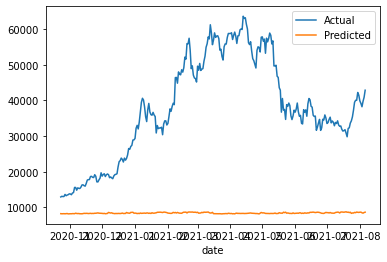

In [ ]:
result_df.plot()

Machine Leaning Classification Model Using LSTM RNN

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [ ]:
X = bitcoin_df[['volume', 'Reddit positive', 'Reddit negative', 'bitcoin']]
y = bitcoin_df['class'].to_frame()

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
X = features(X, list(range(4)), 10)
y = target(y, 0, 10)

In [ ]:
X.shape

(10, 1440, 4)

In [ ]:
X = X.reshape(1440, 10, 4)

In [ ]:
tt_split = int(len(X) * 0.8)
X_train = X[: tt_split]
X_test = X[tt_split :]
y_train = y[: tt_split]
y_test = y[tt_split :]

In [ ]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [ ]:
model = Sequential()
neurons = 30
model.add(LSTM(units=neurons, return_sequences=True, input_shape=(X.shape[1], 4)))
model.add(Dropout(0.2))
model.add(LSTM(units=neurons))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 30)            4200      
                                                                 
 dropout_6 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_7 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_7 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 93        
                                                                 
Total params: 11,613
Trainable params: 11,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop = EarlyStopping(monitor='categorical_accuracy', mode='min', patience=10, verbose=1)

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1, shuffle=False, callbacks=[stop])

Epoch 1/100
231/231 [==============================] - 5s 9ms/step - loss: 0.3196 - categorical_accuracy: 0.9184
Epoch 2/100
231/231 [==============================] - 2s 10ms/step - loss: 0.2187 - categorical_accuracy: 0.9575
Epoch 3/100
231/231 [==============================] - 2s 9ms/step - loss: 0.2137 - categorical_accuracy: 0.9575
Epoch 4/100
231/231 [==============================] - 2s 9ms/step - loss: 0.2146 - categorical_accuracy: 0.9575
Epoch 5/100
231/231 [==============================] - 2s 9ms/step - loss: 0.2069 - categorical_accuracy: 0.9575
Epoch 6/100
231/231 [==============================] - 2s 9ms/step - loss: 0.2063 - categorical_accuracy: 0.9575
Epoch 7/100
231/231 [==============================] - 2s 9ms/step - loss: 0.2084 - categorical_accuracy: 0.9575
Epoch 8/100
231/231 [==============================] - 2s 9ms/step - loss: 0.2103 - categorical_accuracy: 0.9575
Epoch 9/100
231/231 [==============================] - 2s 9ms/step - loss: 0.2077 - categorical

In [ ]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 1s 3ms/step - loss: 0.1700 - categorical_accuracy: 0.9653


[0.16998149454593658, 0.9652777910232544]